In [1]:
import os

from qiskit_ibm_runtime import QiskitRuntimeService

try:
    token = os.environ.get("QISKIT_IBM_TOKEN") or os.environ.get("IBM_QUANTUM_TOKEN")
    if not token:
        raise RuntimeError("Missing IBM Quantum token: set QISKIT_IBM_TOKEN (or IBM_QUANTUM_TOKEN) in your environment")
    QiskitRuntimeService.save_account(
        token=token,
        instance="crn:v1:bluemix:public:quantum-computing:us-east:a/aaada83ceff24b0dae735a783b4fd455:16f3888d-411b-4c08-a124-8637cc2cc749::", # Optional
        overwrite=False,
    )
except Exception as e:
    print(e)
    pass

'Named account (default-ibm-cloud) already exists. Set overwrite=True to overwrite.'


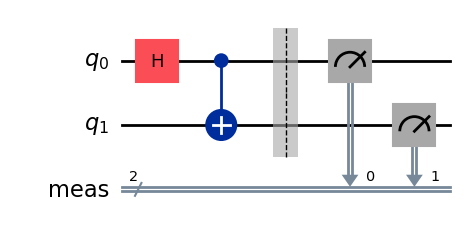

In [4]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
qc.measure_all()
 
# Return a drawing of the circuit using MatPlotLib ("mpl").
# These guides are written by using Jupyter notebooks, which
# display the output of the last line of each cell.
# If you're running this in a script, use `print(qc.draw())` to
# print a text drawing.
qc.draw("mpl")

In [11]:
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

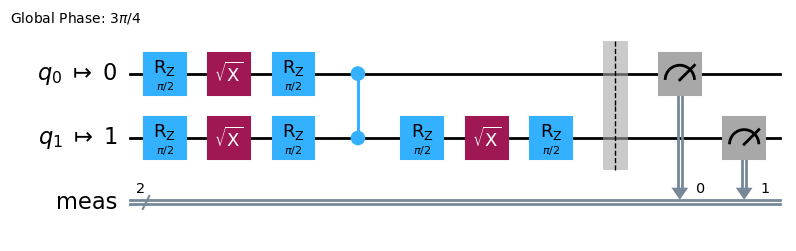

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
isa_circuit.draw("mpl", idle_wires=False)

In [12]:
# Construct the Estimator instance.
 
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])
 
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: d4u4iguaec6c738qutp0


In [14]:
job_result = job.result()
job_result

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(6,), dtype=float64>), stds=np.ndarray(<shape=(6,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(6,), dtype=float64>), shape=(6,)), metadata={'shots': 5024, 'target_precision': 0.01414213562373095, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})

In [16]:
result = job.result()
evs = result[0].data.evs
stds = result[0].data.stds

for label, ev, std in zip(observables_labels, evs, stds):
    print(f"⟨{label}⟩ = {ev:.3f} ± {std:.3f}")

⟨IZ⟩ = -0.017 ± 0.011
⟨IX⟩ = 0.004 ± 0.014
⟨ZI⟩ = -0.034 ± 0.011
⟨XI⟩ = -0.003 ± 0.016
⟨ZZ⟩ = 0.950 ± 0.007
⟨XX⟩ = 0.972 ± 0.006


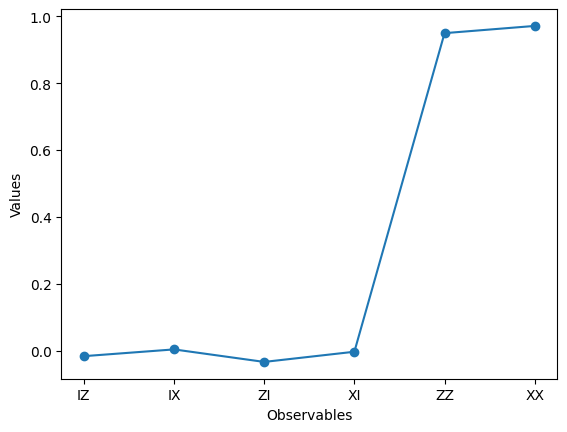

In [18]:
# Plot the result
 
from matplotlib import pyplot as plt

pub_result = job.result()[0]
values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()